## Lab 4: Working with 'real' data

### Jennifer Vo, lab partners with William Olsen

## Introduction

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,7)

## Problem 1

In this problem, I will be looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.

As with most data, there are 'features.' My lab instructor has helpfully incorporated the meta-data into the data file.

### Part 1
First, I downloaded the data from the course website (gammaray_lab4.h5), and imported it into my working environment. I am using cloud python, so I imported this in the terminal using the command: "wget -O gammaray_lab4.h5 https://canvas.uw.edu/courses/1401649/files/67789336/download?wrap=1"

The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. 

In [2]:
# Import file
hf = h5py.File('gammaray_lab4.h5', 'r')

# Import data into an array
data = np.array(hf.get('data'))
# Let's print the first row as an example
print(data[:,0])
hf.close()

[9.40680016e+08 3.15000000e+02 4.50000000e+01 1.00000000e+01]


Next, I will make a few plots, exploring my data and making sure that I understand it. I will start by making scatter plots of the first 150k data points (rows) of the time vs solar phase and the time vs earth longitude. 

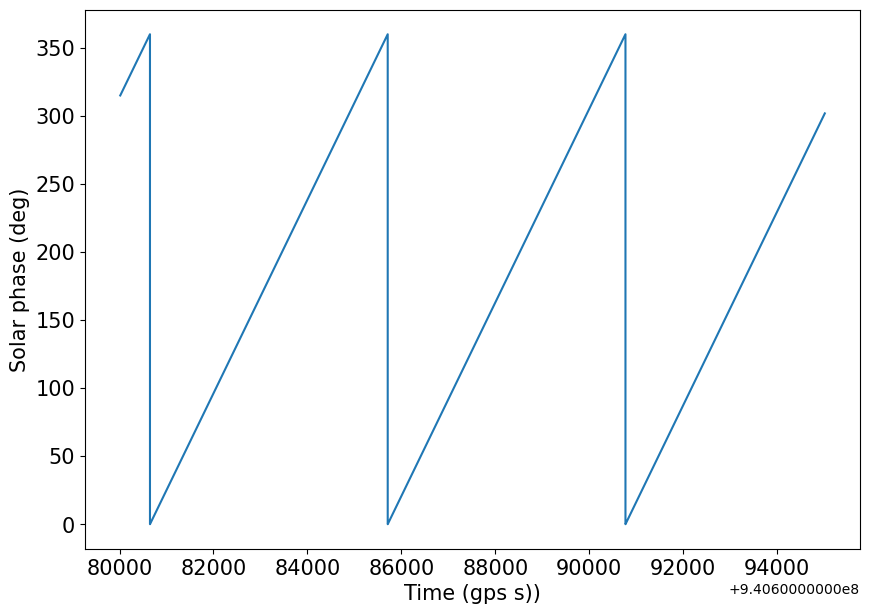

In [3]:
plt.plot(data[0, 0:150000], data[1, 0:150000], '-')
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Solar phase (deg)', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

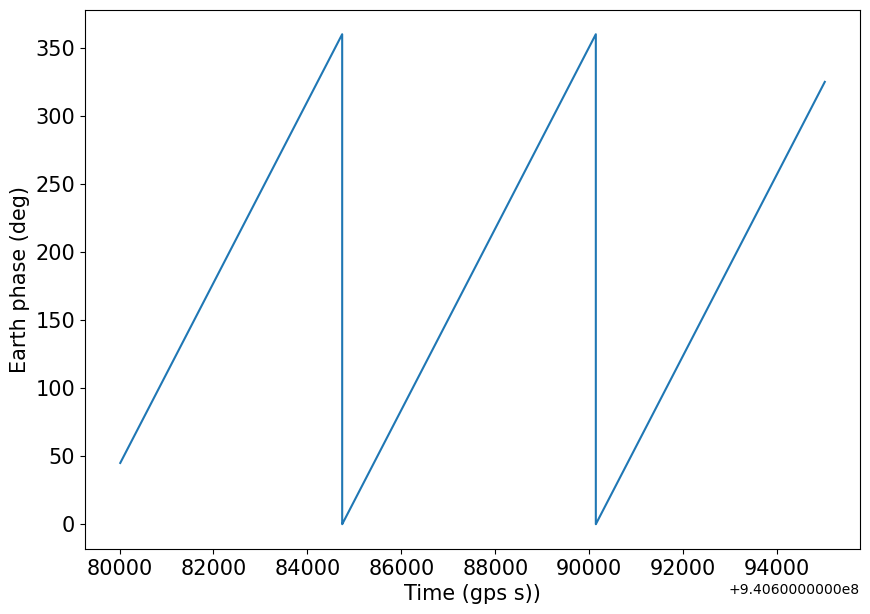

In [4]:
plt.plot(data[0, 0:150000], data[2, 0:150000], '-')
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Earth phase (deg)', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

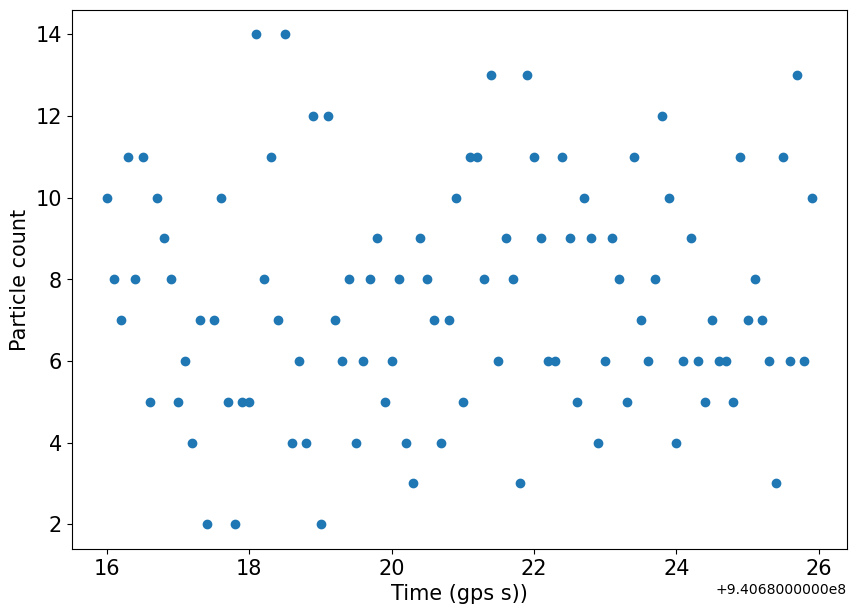

In [5]:
plt.plot(data[0, 0:100], data[3, 0:100], 'o')
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Particle count', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

The time vs particle counts graph appears to have a lot of volatility and did not give much use for plotting the first 150k points, so instead I plotted this with only 100 points of data to clearly show that it is not constant, but rather fluctuates randomly.

From these first 3 scatter plots, I can see that both the Solar phase and Earth phase are positively correlated with time and they both are periodic distributions. I can see that the Solar phase and Earth phase repeat every 360 degrees (or what appears to be every 5400 gps seconds or ~90 minutes) on the time axis. This is expected from the information (the full orbit has a period of 90 minutes).

The particle counts seem to vary with some distribution. I know that the number of particles I can measure with my data collection must be discrete, so I have the choice between two main distributions for the background: Binomial and Poisson. I know that cosmic ray backgrounds are typically modeled by the Poisson distribution, I will choose to try building the background pdf() with a Poisson distribution.

### Part 2
I'd like to explore how the background changes. I will first plot a smear of the data, to see how it changes over a larger period of time. The entire dataset is 25 million records; let's just take a look at 300k samples, but only every 3000 points. This should give us around 100 points on a scatter plot for each graph plotted.

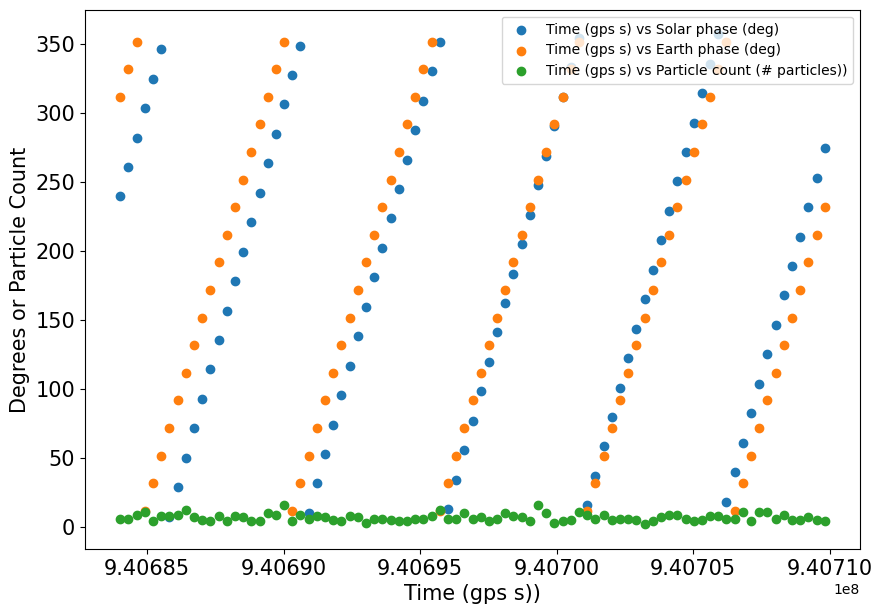

In [6]:
def plot_smear(start, end, steps):
    plt.scatter(data[0, start:end:steps], data[1, start:end:steps], label = 'Time (gps s) vs Solar phase (deg)')
    plt.scatter(data[0, start:end:steps], data[2, start:end:steps], label = 'Time (gps s) vs Earth phase (deg)')
    plt.scatter(data[0, start:end:steps], data[3, start:end:steps], label = 'Time (gps s) vs Particle count (# particles))')

start = 40000
end = 300000
steps = 3000
plot_smear(start, end, steps)
plt.legend()
plt.xlabel('Time (gps s))', fontsize=15)
plt.ylabel('Degrees or Particle Count', fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

For the Solar and Earth phases, they repeat periodically over this larger range of data points. However, it seems that the phases become closer together over time and switch places; the data begins with the Earth phase leading the Solar phase by about ~80 degrees, then about halfway through the 300k data points, they get so close that they overlap and then the Solar phase leads the Earth phase by about ~25 degrees near the end of the 300k data points graphed here. This makes a lot of sense, as the satellite revolves around the Earth and the Earth revolves around the Sun, thus the measurements of the Earth and Solar phase are not going to have the same relationship over any significant amount of time. The entire dataset is 25 million data points, which is 2.5 million gps seconds, or approximately 28.9 days worth of data. Thus, this pattern makes sense and I will ignore it in constructing my model.

What I want to focus on is my particle counts, which are my signals. I see some signal contamination. It appears that the highest values of particle counts are measured when both the Solar phase and Earth phase degrees are high. This could indicate that there is a shift in the average of the particle count value over time, in a periodic pattern.

I would like to explore the relationship of the particle count with both the Solar and the Earth phase, which are both parts of the metadata that would have a direct influence on the particle count.

Let's plot the particle counts and the Solar phase or Earth phase data on 2d histograms to see if we can determine any clear patterns.

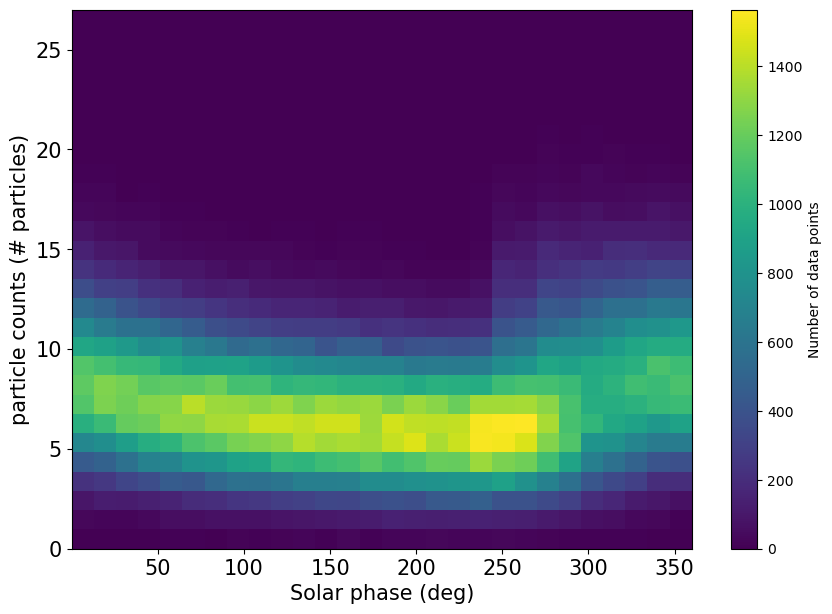

In [7]:
fig, ax = plt.subplots()
h = ax.hist2d(data[1, start:end], data[3, start:end], bins = 28)
fig.colorbar(h[3], ax = ax, label = 'Number of data points')
plt.xlabel('Solar phase (deg)', fontsize = 15)
plt.ylabel('particle counts (# particles)', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

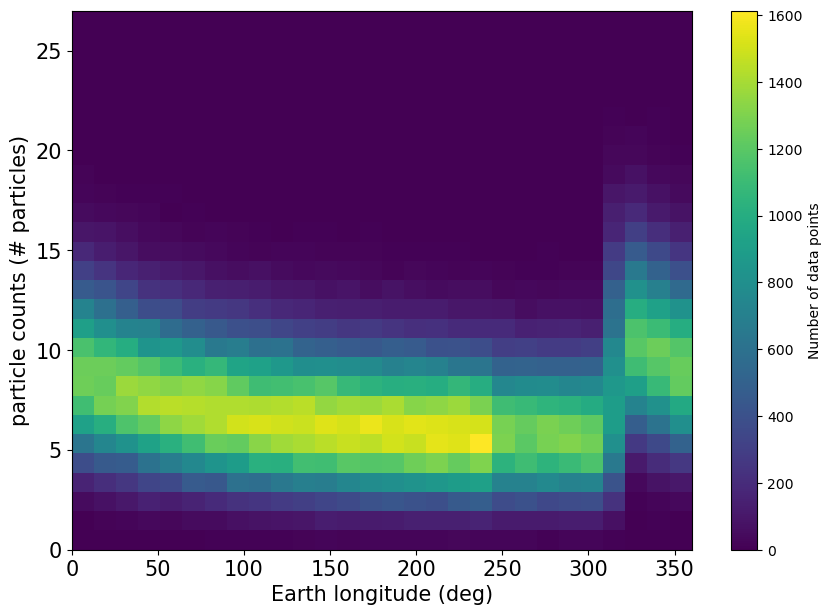

In [8]:
fig, ax = plt.subplots()
h = ax.hist2d(data[2, start:end], data[3, start:end], bins = 28)
fig.colorbar(h[3], ax = ax, label = 'Number of data points')
plt.xlabel('Earth longitude (deg)', fontsize = 15)
plt.ylabel('particle counts (# particles)', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

As we can see, the relationship between the Earth longitude (deg) and the particle counts is much more clear than that of the Solar phase and the particle counts. From this 2d histogram, it appears that the average particle count shifts from higher values to lower values in a periodic pattern. This is a much clearer sign of contamination of the data from the different Earth phases. The average appears to shift from around 10 to around 5 every period.

### Part 3
Next, I will try to create a model for the background that includes time dependence, and then explicitly compare my model to the data.

I will start by shifting the 2d histogram of Earth longitude vs particle counts so that I can approximate an average particle count function, which I will use to construct the Poisson-distributed background.

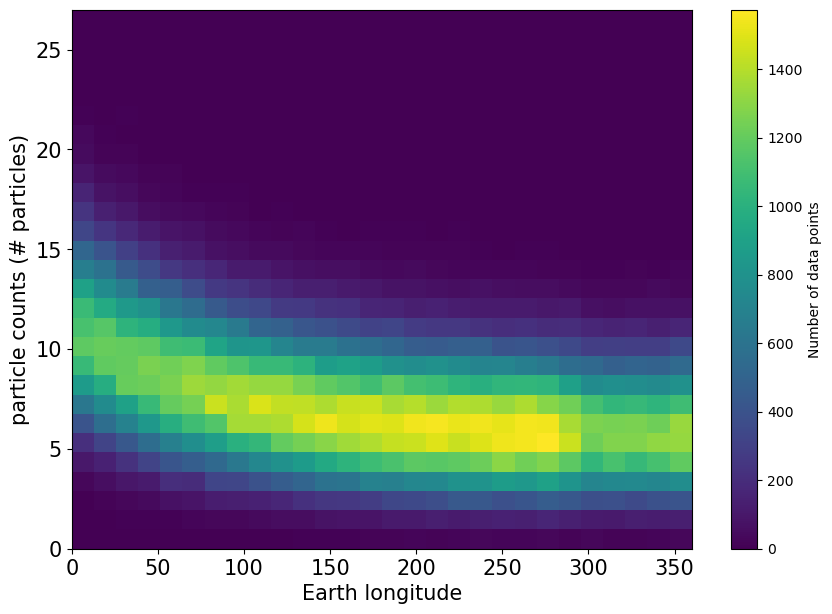

In [9]:
fig, ax = plt.subplots()
h = ax.hist2d((data[2, start:end] - 315) % 360, data[3, start:end], bins = 28)
fig.colorbar(h[3], ax = ax, label = 'Number of data points')
plt.xlabel('Earth longitude', fontsize = 15)
plt.ylabel('particle counts (# particles)', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

With this folded 2d histogram plot, it is much more clear that the average has a maximum of at about 10 particles and a minimum of about 5 particles. The data has a gradually decreasing average particle count from ~10 to ~5, then jumps suddenly back to ~10 to repeat.

These are the parameters I will start with to build my background pdf().

How do I include time dependence in my model so that this Poisson distribution can accurately capture the entirety of the data, with its changing average particle counts? The actual average particle count fluctuations resemble a negative exponential function. I can try to capture this pattern in my model (only over the first period of data). First I will build the average particle count fluctuations, then use that to construct the random variates and plot those along with the actual data to see how well the background model overlaps with the actual data.

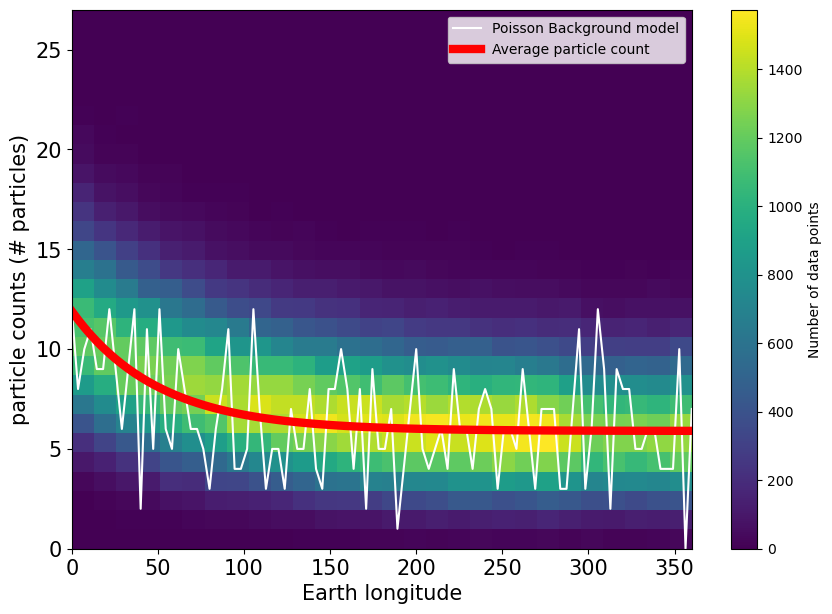

In [10]:
start_model = 0
earth_long_model = np.linspace(start_model, 360, 100) # one full cycle, 100 total steps
lambda_model = 6*np.power(math.e, -earth_long_model/50)+5.9

bkgd_model = stats.poisson.rvs(lambda_model, size=100)

fig, ax = plt.subplots()
h = ax.hist2d((data[2, start:end] - 315) % 360, data[3, start:end], bins = 28)
ax.plot(earth_long_model, bkgd_model, color = 'w', label = 'Poisson Background model')
ax.plot(earth_long_model, lambda_model, linewidth = 6, color = 'r', label = 'Average particle count')
fig.colorbar(h[3], ax = ax, label = 'Number of data points')
plt.xlabel('Earth longitude', fontsize = 15)
plt.ylabel('particle counts (# particles)', fontsize = 15)
plt.tick_params(labelsize=15)
ax.legend()
plt.show()

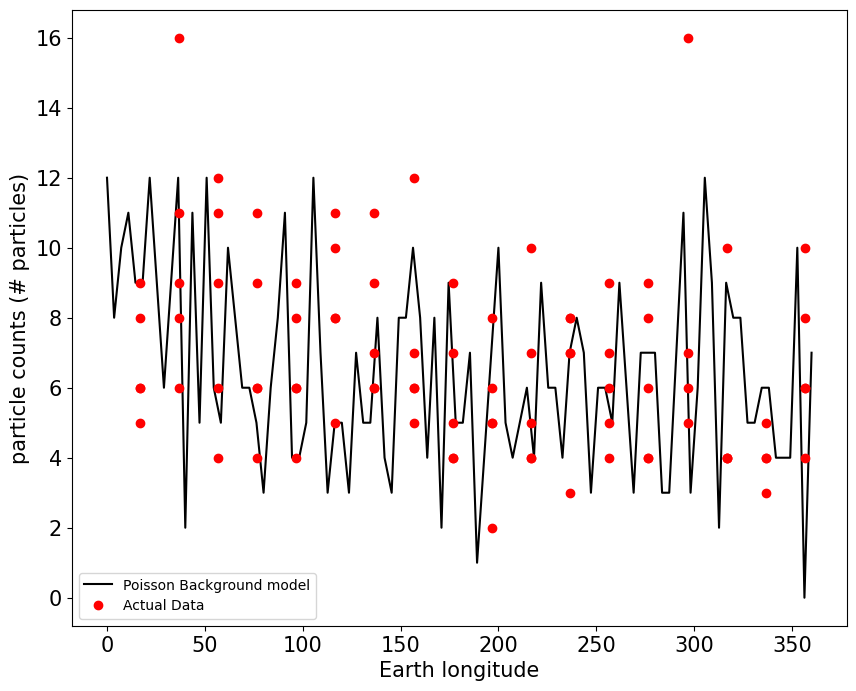

In [25]:
plt.plot(earth_long_model, bkgd_model, color = 'k', label = 'Poisson Background model')
plt.plot((data[2, start:end:steps] - 315) % 360, data[3, start:end:steps], 'o', color = 'r', label = 'Actual Data')
plt.xlabel('Earth longitude', fontsize = 15)
plt.ylabel('particle counts (# particles)', fontsize = 15)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

The equation for my parameter lambda that is used in the Poisson distribution is given by the following, where the Earth longitude is given by y:
$$\lambda(y) = 6 e^{-y/50} + 5.9$$

And the Poisson background model probability distribution of x particle counts is given by
$$ Prob(x) = \frac{\lambda^x e^{-\lambda}}{x!}$$

This model, though based on y (Earth Longitude in degrees), is time-dependent because the Earth phase can be derived from time by the following relationship:
__TO DO LATER: CONVERT TIME TO EARTH PHASE__
$$y = ??? $$

How good is your model of the background? I observe that my model looks pretty close to the actual data of the particle counts.

### Part 4
Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

##### I need to plot the actual PDF of the time-varying Background Poisson distribution in order to complete Part 4.

### Optional Part
While this is simulated data, it is based on a real effect seen by low Earth orbit satellites. Can you identify the cause of the variable background and propose a physical model?

## Problem 2

In this problem I am going to look at a stack of telescope images (again simulated). We have 10 images, but me and my lab partner will be looking for different signals. William will be looking for the faintest stars, while I will be looking for a transient (something like a super novae that only appears in one image).

### Part 1
First I will download the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [12]:
# Import file
hf = h5py.File('images.h5', 'r')

# Import data into an array
imagestack = np.array(hf.get('imagestack'))
image1 = np.array(hf.get('image1'))
hf.close()

### Part 2
I will start by exploring the data, as I did before for Problem 1. Let's first show the first image.

Signal contamination question - explain pixel brightness influenced by star presence, background noise, and transients
Higher pixel value = brighter
Stars are bright and constant pixels
Transient search: subtract the pixels

Is the background time dependent - no; assume the background is Gaussian distributed, and constant in time. Background radiation is constant in time.

Consistent spatially? 

Pixel value = noise + stars + transients
Need to estimate the distribution of the noise
- Get rid of distribution of stars and transients to get the background distribution
- assume the noise is Gaussian distributed

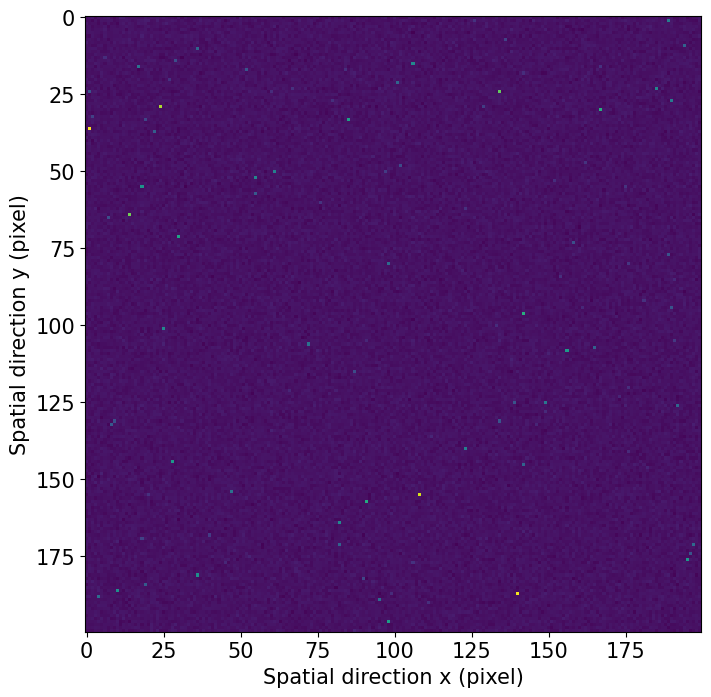

In [26]:
# First adjust the figure size to something useful
plt.rcParams["figure.figsize"] = (10,8)

plt.imshow(imagestack[:,:,0])
plt.xlabel('Spatial direction x (pixel)', fontsize = 15)
plt.ylabel('Spatial direction y (pixel)', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

Here, the telescope image is of a section of the sky. There are several pixels throughout the image which are bright yellow, while others are blue, and some dark blue, and most of them this deep navy.

Let's take a look at a handful of the first few pixel values in image 1, I'll look at the first 2x2 pixels (origin begins at top left corner).

In [24]:
print(imagestack[0,0,0])
print(imagestack[0,1,0])
print(imagestack[1,0,0])
print(imagestack[1,1,0])

-0.5049209253540916
0.3134736734559387
-0.2528844391465269
-0.29488745324834853


Each pixel in the image has a value which represents its intensity. Let's try averaging all of the images together.

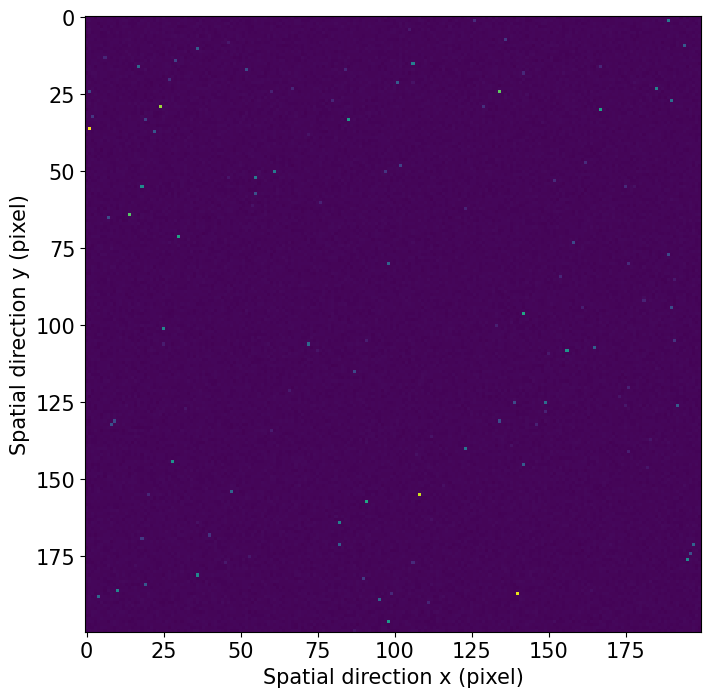

In [46]:
w, h = 200, 200
new_image = [[0 for x in range(w)] for y in range(h)]

for i in range(0,200):
    for j in range(0,200):
        for k in range (0,10):
            new_image[i][j] += imagestack[i,j,k]

        new_image[i][j] = new_image[i][j]/10
        
plt.imshow(new_image)
plt.xlabel('Spatial direction x (pixel)', fontsize = 15)
plt.ylabel('Spatial direction y (pixel)', fontsize = 15)
plt.tick_params(labelsize=15)
plt.show()

Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

### Part 3
Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.
- Start with the original images, use the background distribution. Threshold of 5 sigma -> transient is outside that threshold.

### Part 4
You and your lab partner had different pdf(), but were using the same data. Explore why this is.